## Variability of L1 IN activity across vigilance states

In [1]:
import quantities as pq
import numpy as np
import math 
import neo
import json
import pickle
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget


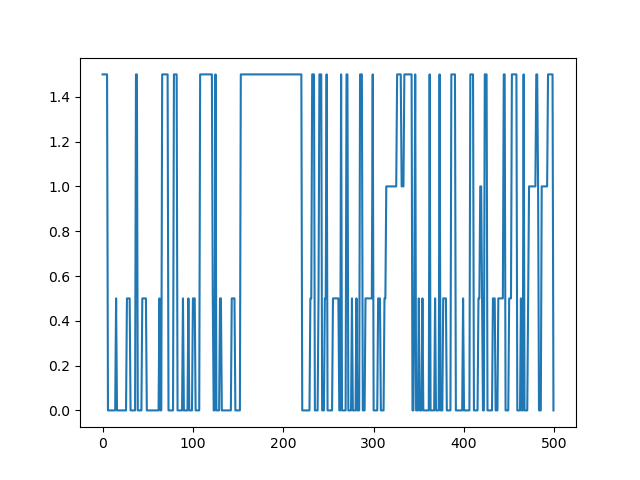

In [14]:
folder_base = Path('/Users/ahay/Documents/DATA/DREADDthalamus/2206/')
scoringFile = folder_base / f'ScoredSleep.npy'
scoringF = np.load(scoringFile)
scoringFS = scoringF[1500:2000]

plt.close()
plt.plot(scoringFS)
plt.show()

Load sleep score, intensity Ca2+ for all sessions + mappings (requires 11, 12, cross-registration)

In [11]:
folder_base = Path('/Users/ahay/Documents/DATA/DREADDthalamus/2206/')
sessions = 3

mfile = open('Gaelle/Baseline_recording/BlackLinesOK/session1/V4_Miniscope/mappings.pkl', 'rb')
mapping = pickle.load(mfile)

dict_Int = {}
dict_Scoring = {}
for x in range(1, sessions+1):
    IntensityFile = folder_base / f'session{x}/IntensityNormalisedVigilanceStates.xlsx' #
    dict_Int["session{0}".format(x)] = pd.read_excel(IntensityFile)
    ScoringFile = folder_base / f'OpenEphys/ScoredSleep.npy' #session{x}/
    dict_Scoring["session{0}".format(x)] = np.load(ScoringFile)
    

from scoring, time spent in each stage.

In [12]:
data = {
    'Wake' : np.zeros(sessions),
    'NREM' : np.zeros(sessions),
    'N2' : np.zeros(sessions),
    'REM' : np.zeros(sessions),
}
Activity_state_time = pd.DataFrame(data, columns=['Wake', 'NREM', 'N2', 'REM'])

counter = 0
for i in dict_Scoring:
    A = dict_Scoring[i]
    for time_stamp in range(len(A)):
        if(A[time_stamp] == 1):
            Activity_state_time["REM"][counter] = Activity_state_time["REM"][counter] + 1   
        elif(A[time_stamp] == 0.5):
            Activity_state_time["N2"][counter] = Activity_state_time["N2"][counter] + 1
        elif(A[time_stamp] == 1.5):
            Activity_state_time["Wake"][counter] = Activity_state_time["Wake"][counter] + 1    
        elif(A[time_stamp] == 0):
            Activity_state_time["NREM"][counter] = Activity_state_time["NREM"][counter] + 1 
    counter = counter + 1


In [14]:
units = len(mapping)
B = mapping['session']
# this is only necessary in case the final session analysed are not the same as used for cross-registration
B = B[['session11', 'session12', 'session13']]#, 'session4', 'session5']] 

data = {
    'sessions': np.zeros(units),
    'Wake' : np.zeros(units),
    'NREM' : np.zeros(units),
    'N2' : np.zeros(units),
    'REM' : np.zeros(units),
    'AllSleep' : np.zeros(units),
    'AllNREM' : np.zeros(units),
}
Activity_Per_Neurons = pd.DataFrame(data, columns=['sessions', 'Wake', 'NREM', 'N2', 'REM', 'AllSleep', 'AllNREM'])
for unit in range(units):
    counter = 0
    counter2 = 0
    time_wake = 0
    time_NREM = 0
    time_REM = 0
    time_N2 = 0
    time_AllSleep = 0
    time_AllNREM = 0
    for i in B:
        if math.isnan (float(B[i][unit])) == False:
            counter = counter + 1
            unit_id = int(float(B[i][unit]))
            Activity_Per_Neurons['sessions'][unit] = counter
            Unit_id_rank = [x for x in range(len(dict_Int[i]['Unit'])) if dict_Int[i]['Unit'][x] == unit_id]
            if Unit_id_rank != [] and Activity_Per_Neurons['sessions'][unit] > 0:
                Activity_Per_Neurons['Wake'][unit] += dict_Int[i]['Wake'][Unit_id_rank]*Activity_state_time["Wake"][counter2]
                Activity_Per_Neurons['REM'][unit] += dict_Int[i]['REM'][Unit_id_rank]*Activity_state_time["REM"][counter2]
                Activity_Per_Neurons['NREM'][unit] += dict_Int[i]['NREM'][Unit_id_rank]*Activity_state_time["NREM"][counter2]
                Activity_Per_Neurons['N2'][unit] += dict_Int[i]['N2'][Unit_id_rank]*Activity_state_time["N2"][counter2]
                Activity_Per_Neurons['AllSleep'][unit] = Activity_Per_Neurons['REM'][unit] + Activity_Per_Neurons['NREM'][unit] + Activity_Per_Neurons['N2'][unit]
                Activity_Per_Neurons['AllNREM'][unit] = Activity_Per_Neurons['NREM'][unit] + Activity_Per_Neurons['N2'][unit]
                time_wake += Activity_state_time["Wake"][counter2]
                time_NREM += Activity_state_time["NREM"][counter2]
                time_REM += Activity_state_time["REM"][counter2]
                time_N2 += Activity_state_time["N2"][counter2]
        counter2 = counter2 + 1
    time_AllSleep = time_NREM + time_REM + time_N2
    time_AllNREM = time_NREM + time_N2
    if(time_wake > 0):
        Activity_Per_Neurons['Wake'][unit] /= time_wake
        Activity_Per_Neurons['NREM'][unit] /= time_NREM
        Activity_Per_Neurons['REM'][unit] /= time_REM
        Activity_Per_Neurons['N2'][unit] /= time_N2
        Activity_Per_Neurons['AllSleep'][unit] /= time_AllSleep
        Activity_Per_Neurons['AllNREM'][unit] /= time_AllNREM



KeyError: 'session11'

In [164]:
Activity_Per_Neurons
filenameOut = folder_base / f'Activity_Per_Neurons_13.xlsx'
writer = pd.ExcelWriter(filenameOut)
Activity_Per_Neurons.to_excel(writer)
writer.save()

In [204]:
# here we select the X% highest values for each state to determine the threshold set at the minimum of them
X = 15 # %

NumbValue = int(len(Activity_Per_Neurons)/X)
listele = []
ANREM = Activity_Per_Neurons.nlargest(NumbValue, 'NREM')
AREM = Activity_Per_Neurons.nlargest(NumbValue, 'REM')
AWake = Activity_Per_Neurons.nlargest(NumbValue, 'Wake')
AN2 = Activity_Per_Neurons.nlargest(NumbValue, 'N2')
listele = ANREM['NREM'].tolist() + AREM['REM'].tolist() + AWake['Wake'].tolist() + AN2['N2'].tolist()
threshold = min(listele)


In [202]:
threshold = min(listele)

data = {
    'sessions': np.zeros(units),
    'Wake' : np.zeros(units),
    'NREM' : np.zeros(units),
    'N2' : np.zeros(units),
    'REM' : np.zeros(units),
    'AllSleep' : np.zeros(units),
    'AllNREM' : np.zeros(units),
    'AllTime' : np.zeros(units),
    'WakeREM' : np.zeros(units),
}
Summary_activity = pd.DataFrame(data, columns=['sessions', 'Wake', 'NREM', 'N2', 'REM', 'AllSleep', 'AllNREM', 'AllTime', 'WakeREM'])
sumSummary_activity = pd.Series([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], index=['sessions', 'Wake', 'NREM', 'N2', 'REM', 'AllSleep', 'AllNREM', 'AllTime', 'WakeREM', 'N2only', 'NREMonly', 'REMonly', 'N2REMonly', 'Wakeonly', 'Sleeponly', 'SparseActivity'])
for unit in range(units):
    counter = 0
    if Activity_Per_Neurons['sessions'][unit] > 0.5:
        Summary_activity['sessions'][unit] = Activity_Per_Neurons['sessions'][unit]
        sumSummary_activity['sessions'] += 1 
        if Activity_Per_Neurons['Wake'][unit] > threshold:
            Summary_activity['Wake'][unit] += 1
            sumSummary_activity['Wake'] += 1 
        if Activity_Per_Neurons['NREM'][unit] > threshold:
            Summary_activity['NREM'][unit] += 1
            sumSummary_activity['NREM'] += 1 
        if Activity_Per_Neurons['REM'][unit] > threshold:
            Summary_activity['REM'][unit] += 1
            sumSummary_activity['REM'] += 1 
        if Activity_Per_Neurons['N2'][unit] > threshold:
            Summary_activity['N2'][unit] += 1
            sumSummary_activity['N2'] += 1 
        if Activity_Per_Neurons['AllSleep'][unit] > threshold:
            Summary_activity['AllSleep'][unit] += 1
            sumSummary_activity['AllSleep'] += 1 
        if Activity_Per_Neurons['AllNREM'][unit] > threshold:
            Summary_activity['AllNREM'][unit] += 1
            sumSummary_activity['AllNREM'] += 1 
        if Summary_activity['AllTime'][unit] == 1 and Summary_activity['Wake'][unit] == 1:
            Summary_activity['AllTime'][unit] += 1
            sumSummary_activity['AllTime'] += 1 
        if Summary_activity['Wake'][unit] == 1 and Summary_activity['REM'][unit] == 1:
            Summary_activity['WakeREM'][unit] += 1
            sumSummary_activity['WakeREM'] += 1 
        if Summary_activity['N2'][unit] == 1 and Summary_activity['Wake'][unit] == 0 and Summary_activity['NREM'][unit] == 0 and Summary_activity['REM'][unit] == 0:
            sumSummary_activity['N2only'] += 1
        if Summary_activity['N2'][unit] == 0 and Summary_activity['Wake'][unit] == 1 and Summary_activity['NREM'][unit] == 0 and Summary_activity['REM'][unit] == 0:
            sumSummary_activity['Wakeonly'] += 1
        if Summary_activity['N2'][unit] == 0 and Summary_activity['Wake'][unit] == 0 and Summary_activity['NREM'][unit] == 0 and Summary_activity['REM'][unit] == 1:
            sumSummary_activity['REMonly'] += 1
        if Summary_activity['N2'][unit] == 1 and Summary_activity['Wake'][unit] == 0 and Summary_activity['NREM'][unit] == 1 and Summary_activity['REM'][unit] == 0:
            sumSummary_activity['NREMonly'] += 1
        if Summary_activity['N2'][unit] == 1 and Summary_activity['Wake'][unit] == 0 and Summary_activity['NREM'][unit] == 0 and Summary_activity['REM'][unit] == 1:
            sumSummary_activity['N2REMonly'] += 1
        if Summary_activity['N2'][unit] == 1 and Summary_activity['Wake'][unit] == 0 and Summary_activity['NREM'][unit] == 1 and Summary_activity['REM'][unit] == 1:
            sumSummary_activity['Sleeponly'] += 1
        if Summary_activity['N2'][unit] == 0 and Summary_activity['Wake'][unit] == 0 and Summary_activity['NREM'][unit] == 0 and Summary_activity['REM'][unit] == 0:
            sumSummary_activity['SparseActivity'] += 1



#filenameOut = folder_base / f'Summary_Activity_13.xlsx'
#writer = pd.ExcelWriter(filenameOut)
#Summary_activity.to_excel(writer)
#writer.save()


More specifically here, looking for very specifically activated neurons

In [203]:
thresholdLow = min(listele)
thresholdHigh = 150

data = {
    'sessions': np.zeros(units),
    'Wake' : np.zeros(units),
    'NREM' : np.zeros(units),
    'N2' : np.zeros(units),
    'REM' : np.zeros(units),
}
Summary_activity2 = pd.DataFrame(data, columns=['sessions', 'Wake', 'NREM', 'N2', 'REM'])
Specific_activity = pd.Series([0, 0, 0, 0, 0, 0, 0, 0], index=['Total','NREMspe', 'REMspe', 'WakeREMspe', 'Wakespe', 'Sleepspe', 'Nonspe', 'SparseActivity'])

for unit in range(units):
    counter = 0
    if Activity_Per_Neurons['sessions'][unit] > 0.5:
        Summary_activity2['sessions'][unit] = Activity_Per_Neurons['sessions'][unit]
        Specific_activity['Total'] += 1
        if Activity_Per_Neurons['Wake'][unit] > thresholdLow:
            Summary_activity2['Wake'][unit] += 1
        if Activity_Per_Neurons['NREM'][unit] > thresholdLow:
            Summary_activity2['NREM'][unit] += 1
        if Activity_Per_Neurons['REM'][unit] > thresholdLow:
            Summary_activity2['REM'][unit] += 1
        if Activity_Per_Neurons['N2'][unit] > thresholdLow:
            Summary_activity2['N2'][unit] += 1
        if Activity_Per_Neurons['Wake'][unit] > thresholdHigh:
            Summary_activity2['Wake'][unit] += 1
        if Activity_Per_Neurons['NREM'][unit] > thresholdHigh:
            Summary_activity2['NREM'][unit] += 1
        if Activity_Per_Neurons['REM'][unit] > thresholdHigh:
            Summary_activity2['REM'][unit] += 1
        if Activity_Per_Neurons['N2'][unit] > thresholdHigh:
            Summary_activity2['N2'][unit] += 1

        if Summary_activity2['Wake'][unit] == 0 and Summary_activity2['NREM'][unit] > 1 and Summary_activity2['REM'][unit] == 0:
            Specific_activity['NREMspe'] += 1
        elif Summary_activity2['N2'][unit] > 1 and Summary_activity2['Wake'][unit] == 0 and Summary_activity2['REM'][unit] == 0:
            Specific_activity['NREMspe'] += 1
        elif Summary_activity2['N2'][unit] == 0 and Summary_activity2['Wake'][unit] > 1 and Summary_activity2['NREM'][unit] == 0 and Summary_activity2['REM'][unit] == 0:
            Specific_activity['Wakespe'] += 1
        elif Summary_activity2['N2'][unit] < 2 and Summary_activity2['Wake'][unit] == 0 and Summary_activity2['NREM'][unit] == 0 and Summary_activity2['REM'][unit] > 1:
            Specific_activity['REMspe'] += 1
        elif Summary_activity2['N2'][unit] > 1 and Summary_activity2['Wake'][unit] == 0 and Summary_activity2['REM'][unit] > 1:
            Specific_activity['Sleepspe'] += 1
        elif Summary_activity2['Wake'][unit] == 0 and Summary_activity2['NREM'][unit] > 1 and Summary_activity2['REM'][unit] > 1:
            Specific_activity['Sleepspe'] += 1
        elif Summary_activity2['N2'][unit] == 0 and Summary_activity2['Wake'][unit] == 0 and Summary_activity2['NREM'][unit] == 0 and Summary_activity2['REM'][unit] == 0:
            Specific_activity['SparseActivity'] += 1
        elif Summary_activity2['N2'][unit] == 0 and Summary_activity2['Wake'][unit] > 1 and Summary_activity2['NREM'][unit] == 0 and Summary_activity2['REM'][unit] > 1:
            Specific_activity['WakeREMspe'] += 1
        else:
            Specific_activity['Nonspe'] += 1
       

filenameOut = folder_base / f'StageActiveInactive_13.xlsx'
writer = pd.ExcelWriter(filenameOut)
Specific_activity.to_excel(writer)
writer.save()
Specific_activity

Total             48
NREMspe            3
REMspe             4
WakeREMspe         1
Wakespe            4
Sleepspe           1
Nonspe            10
SparseActivity    25
dtype: int64

Last attempt with relative thresholding

In [212]:
# here we select the X% highest values for each state to determine the threshold set at the minimum of them
X = 20 # %

NumbValue = int(len(Activity_Per_Neurons)/X)
listele = []
ANREM = Activity_Per_Neurons.nlargest(NumbValue, 'NREM')
AREM = Activity_Per_Neurons.nlargest(NumbValue, 'REM')
AWake = Activity_Per_Neurons.nlargest(NumbValue, 'Wake')
AN2 = Activity_Per_Neurons.nlargest(NumbValue, 'N2')
listele = ANREM['NREM'].tolist() + AREM['REM'].tolist() + AWake['Wake'].tolist() + AN2['N2'].tolist()

thresholdLow = min(listele)
factor = 1.3

data = {
    'sessions': np.zeros(units),
    'Wake' : np.zeros(units),
    'NREM' : np.zeros(units),
    'N2' : np.zeros(units),
    'REM' : np.zeros(units),
    'WakeREM' : np.zeros(units),
}
Summary_activity2 = pd.DataFrame(data, columns=['sessions', 'Wake', 'NREM', 'N2', 'REM', 'WakeREM'])
Specific_activity = pd.Series([0, 0, 0, 0, 0, 0, 0, 0], index=['Total','NREMspe', 'REMspe', 'WakeREMspe', 'Wakespe', 'Sleepspe', 'Nonspe', 'SparseActivity'])

for unit in range(units):
    counter = 0
    if Activity_Per_Neurons['sessions'][unit] > 0.5:
        Summary_activity2['sessions'][unit] = Activity_Per_Neurons['sessions'][unit]
        Specific_activity['Total'] += 1
        if Activity_Per_Neurons['Wake'][unit] > thresholdLow:
            Summary_activity2['Wake'][unit] += 1
        if Activity_Per_Neurons['NREM'][unit] > thresholdLow:
            Summary_activity2['NREM'][unit] += 1
        if Activity_Per_Neurons['REM'][unit] > thresholdLow:
            Summary_activity2['REM'][unit] += 1
        if Activity_Per_Neurons['N2'][unit] > thresholdLow:
            Summary_activity2['N2'][unit] += 1
        if Activity_Per_Neurons['Wake'][unit] > factor*(Activity_Per_Neurons['NREM'][unit]+Activity_Per_Neurons['REM'][unit]+Activity_Per_Neurons['N2'][unit]):
            Summary_activity2['Wake'][unit] += 1
        if Activity_Per_Neurons['NREM'][unit] > factor*(Activity_Per_Neurons['Wake'][unit]+Activity_Per_Neurons['REM'][unit]+Activity_Per_Neurons['N2'][unit]):
            Summary_activity2['NREM'][unit] += 1
        if Activity_Per_Neurons['REM'][unit] > factor*(Activity_Per_Neurons['NREM'][unit]+Activity_Per_Neurons['Wake'][unit]+Activity_Per_Neurons['N2'][unit]):
            Summary_activity2['REM'][unit] += 1
        if Activity_Per_Neurons['N2'][unit] > factor*(Activity_Per_Neurons['NREM'][unit]+Activity_Per_Neurons['REM'][unit]+Activity_Per_Neurons['Wake'][unit]):
            Summary_activity2['N2'][unit] += 1
        if Activity_Per_Neurons['REM'][unit] > 2*factor*(Activity_Per_Neurons['NREM'][unit] + Activity_Per_Neurons['N2'][unit]) and Activity_Per_Neurons['Wake'][unit] > 2*factor*(Activity_Per_Neurons['NREM'][unit] + Activity_Per_Neurons['N2'][unit]):
            Summary_activity2['WakeREM'][unit] += 2

        if Summary_activity2['Wake'][unit] == 0 and Summary_activity2['NREM'][unit] > 1 and Summary_activity2['REM'][unit] == 0:
            Specific_activity['NREMspe'] += 1
        elif Summary_activity2['N2'][unit] > 1 and Summary_activity2['Wake'][unit] == 0 and Summary_activity2['REM'][unit] == 0:
            Specific_activity['NREMspe'] += 1
        elif Summary_activity2['N2'][unit] == 0 and Summary_activity2['Wake'][unit] > 1 and Summary_activity2['NREM'][unit] == 0 and Summary_activity2['REM'][unit] == 0:
            Specific_activity['Wakespe'] += 1
        elif Summary_activity2['N2'][unit] < 2 and Summary_activity2['Wake'][unit] == 0 and Summary_activity2['NREM'][unit] == 0 and Summary_activity2['REM'][unit] > 1:
            Specific_activity['REMspe'] += 1
        elif Summary_activity2['N2'][unit] > 1 and Summary_activity2['Wake'][unit] == 0 and Summary_activity2['REM'][unit] > 1:
            Specific_activity['Sleepspe'] += 1
        elif Summary_activity2['Wake'][unit] == 0 and Summary_activity2['NREM'][unit] > 1 and Summary_activity2['REM'][unit] > 1:
            Specific_activity['Sleepspe'] += 1
        elif Summary_activity2['N2'][unit] == 0 and Summary_activity2['Wake'][unit] == 0 and Summary_activity2['NREM'][unit] == 0 and Summary_activity2['REM'][unit] == 0:
            Specific_activity['SparseActivity'] += 1
        elif Summary_activity2['N2'][unit] == 0 and Summary_activity2['WakeREM'][unit] > 1 and Summary_activity2['NREM'][unit] == 0:
            Specific_activity['WakeREMspe'] += 1
        else:
            Specific_activity['Nonspe'] += 1
       

#filenameOut = folder_base / f'StageActiveInactive_13.xlsx'
#writer = pd.ExcelWriter(filenameOut)
#Specific_activity.to_excel(writer)
#writer.save()
Specific_activity

Total             48
NREMspe            3
REMspe             7
WakeREMspe         1
Wakespe            4
Sleepspe           0
Nonspe             5
SparseActivity    28
dtype: int64